# Import dependencies

In [1]:
import requests
import json
from IPython.display import display
from pathlib import Path
from zipfile import ZipFile
import glob
import numpy as np
import netCDF4 as nc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Check API is available

In [ ]:
response = requests.get("http://host.docker.internal:8080/argo-toolbox/api/decoder/docs/", timeout=5)
if(response.status_code == 200):
    print("✅ Decoder API available")

# Set file paths and WMONUM

In [ ]:
file_dir = r"/home/jovyan/examples//data/6902892_raw"
float_info = r"/home/jovyan/examples//floats_meta/6902892/float_info.json"
meta_info = r"/home/jovyan/examples//floats_meta/6902892/meta_info.json"
wmonum = "6902892"

# Load float metadata

In [ ]:
with open(float_info) as file:
   float_info = json.loads(file.read())

with open(meta_info) as file:
   meta_info = json.loads(file.read())

# Example Extra args, used to pass to the decoder and overwrite the default configuration.
extra_args = {"DIR_OUTPUT_XML_FILE" : "/mnt/data/output/xml/",}

meta_data = {
    "float_metadata": json.dumps({
        "float_info": float_info,
        "float_meta_info": meta_info,
    }),
     "configuration_override": json.dumps(extra_args),  # optional
}

# Open files and send request to decoder API

In [ ]:
DECODER_URL = "http://host.docker.internal:8080/argo-toolbox/api/decoder/decode_float"

url = f"{DECODER_URL}/{wmonum}"
files = [("files", (str(Path(file_path).name), open(file_path, "rb"), "text/plain")) for file_path in Path(file_dir).glob("*.txt")]

handle = display("⏳ Decoding…", display_id=True)
response = requests.post(
            url,
            files=files,
            data=meta_data
        )
handle.update(f"✅ Done (status {response.status_code})")
for _, (name, file_obj, _) in files:
    file_obj.close()

# Download ZIP file generated by decoder

In [ ]:
dir = Path("/home/jovyan/examples/output") / wmonum
dir.mkdir(parents=True, exist_ok=True)
open(dir / f"{wmonum}.zip", "wb").write(response.content)

# Extract ZIP file

In [ ]:
with ZipFile(dir / f"{wmonum}.zip", "r") as zObject:
    zObject.extractall(path= dir / "unzipped")

# Open dataset

In [ ]:
output_path = f"/home/jovyan/examples/output/{wmonum}/unzipped/tmp/*/{wmonum}/profiles/R6902892_001.nc"
matches = glob.glob(output_path)

if matches:
    dataset_file = matches[0]
else:
    print("No matching file found.")

ds = xr.open_dataset(dataset_file, decode_timedelta=False)

# Plot variables

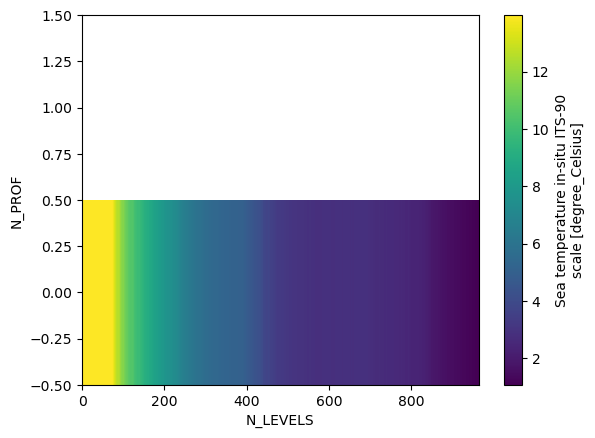

In [13]:
ds.TEMP.plot()

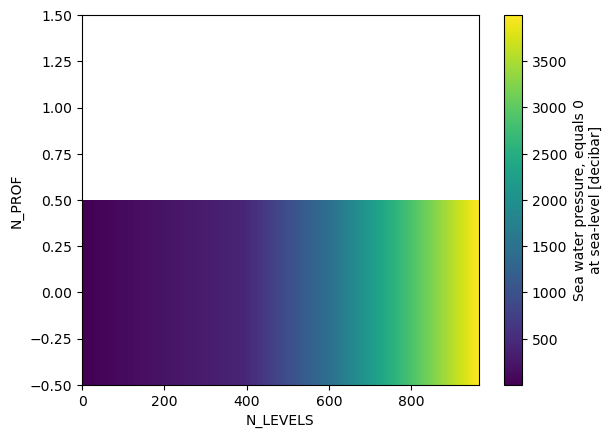

In [14]:
ds.PRES_ADJUSTED.plot()

In [ ]:
df = ds.to_dataframe()

In [22]:
param_temp = df.groupby('N_PARAM')['TEMP_ADJUSTED'].count().idxmax()

# And salinity if needed
param_psal = df.groupby('N_PARAM')['PSAL_ADJUSTED'].count().idxmax()

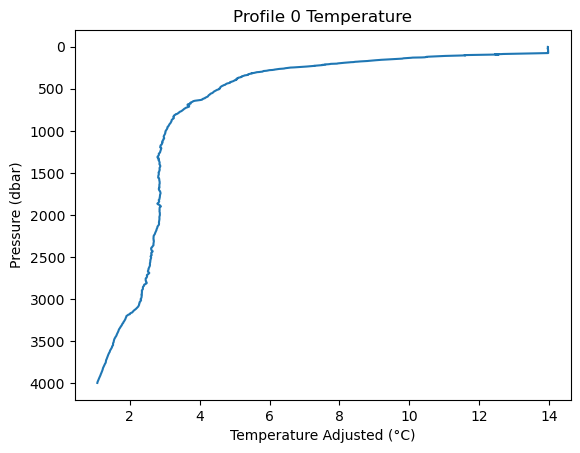

In [23]:
profile_id = 0  # choose a profile

prof = df.xs((profile_id, param_temp), level=('N_PROF', 'N_PARAM'))
prof = prof[['PRES', 'TEMP_ADJUSTED']].dropna()

plt.plot(prof['TEMP_ADJUSTED'], prof['PRES'])
plt.gca().invert_yaxis()
plt.xlabel('Temperature Adjusted (°C)')
plt.ylabel('Pressure (dbar)')
plt.title(f'Profile {profile_id} Temperature')
plt.show()

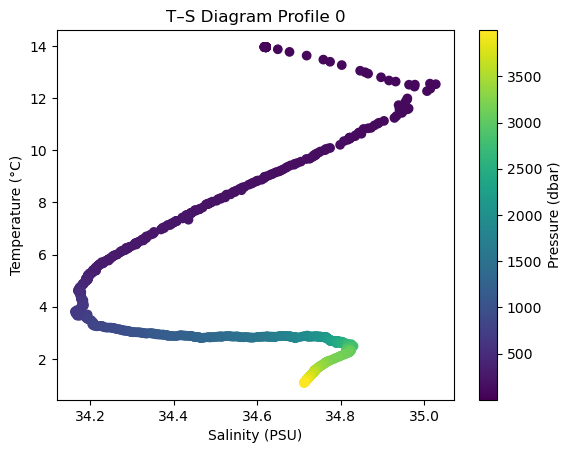

In [25]:
prof = df.xs((profile_id, param_temp), level=('N_PROF','N_PARAM'))
prof = prof[['PRES', 'TEMP_ADJUSTED', 'PSAL_ADJUSTED']].dropna()

plt.scatter(prof['PSAL_ADJUSTED'], prof['TEMP_ADJUSTED'], c=prof['PRES'])
plt.colorbar(label='Pressure (dbar)')
plt.xlabel('Salinity (PSU)')
plt.ylabel('Temperature (°C)')
plt.title(f'T–S Diagram Profile {profile_id}')
plt.show()